# Poisson Linear Dynamical System

In this notebook we look at a generalization of the canonical Linear Dynamical System (LDS) model to be able to handle Poisson observations. This model is called the "Poisson Linear Dynamical System." We lack the ability to directly compute the psoterior distribution of the latent states in this model, so we will use a LaPlace approximation. For more information, see the paper "Empirical Models of Spiking in Neural Populations" by Macke et al. (2011).

## Setup

In [1]:
# import the relevant packages
using StateSpaceDynamics
using LinearAlgebra
using Random
using Plots
using LaTeXStrings

## Simulate data from a Poisson LDS model

In [2]:
# create a state-space model for the tutorial
obs_dim = 10
latent_dim = 2

# set up the state parameters
A = 0.95 * [cos(0.25) -sin(0.25); sin(0.25) cos(0.25)] 
Q = Matrix(0.1 * I(2))

x0 = [0.0; 0.0]
P0 = Matrix(0.1 * I(2))

# set up the observation parameters
log_d = log.(fill(0.1, 10))
C = permutedims([abs.(randn(10))'; abs.(randn(10))'])


# create the state-space model
true_ssm = PoissonLDS(;A=A, 
                        Q=Q, 
                        C=C,
                        log_d=log_d, 
                        x0=x0, 
                        P0=P0, 
                        obs_dim=obs_dim, 
                        latent_dim=latent_dim, 
                        fit_bool=fill(true, 6))

# simulate data from the model
tSteps = 500
latents, observations = StateSpaceDynamics.sample(true_ssm, tSteps, 1) # one trial for tutorial purposes

([-0.05130526329548263 -0.10385993206052307 … 0.34442196755347265 0.41560234180583144; -0.05761016563455378 -0.13678309813524892 … -0.14920673261513795 0.22586516071598;;;], [2.0 0.0 … 2.0 1.0; 0.0 0.0 … 1.0 2.0; … ; 1.0 0.0 … 0.0 3.0; 1.0 0.0 … 3.0 4.0;;;])

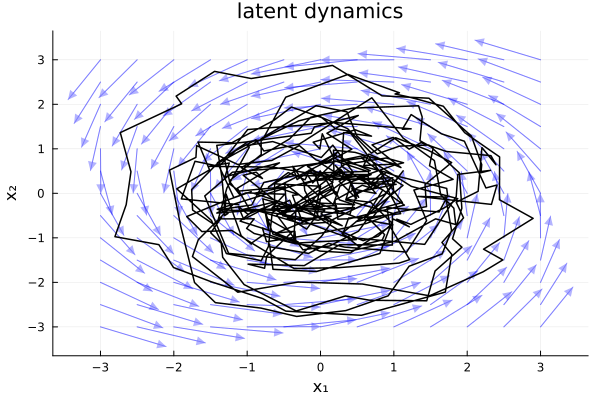

In [3]:
# Create a grid for the vector field
x = y = -3:0.5:3
X = repeat(x', length(y), 1)
Y = repeat(y, 1, length(x))

# Assuming x and y are your grid points
U = zeros(size(X))
V = zeros(size(Y))
for i in 1:size(X, 1)
    for j in 1:size(X, 2)
        v = A * [X[i,j], Y[i,j]]
        U[i,j] = v[1] - X[i,j]  # Change in x
        V[i,j] = v[2] - Y[i,j]  # Change in y
    end
end
# Normalize the vectors for better visualization
magnitude = @. sqrt(U^2 + V^2)
U_norm, V_norm = U ./ magnitude, V ./ magnitude

magnitude = @. sqrt(U^2 + V^2)
U_norm = U ./ magnitude
V_norm = V ./ magnitude

# Plot
p = quiver(X, Y, quiver=(U_norm, V_norm), color=:blue, alpha=0.3,
           linewidth=1, arrow=arrow(:closed, :head, 0.1, 0.1))
plot!(latents[1, :, 1], latents[2, :, 1], xlabel="x₁", ylabel="x₂", color=:black, linewidth=1.5, title="latent dynamics", legend=false)

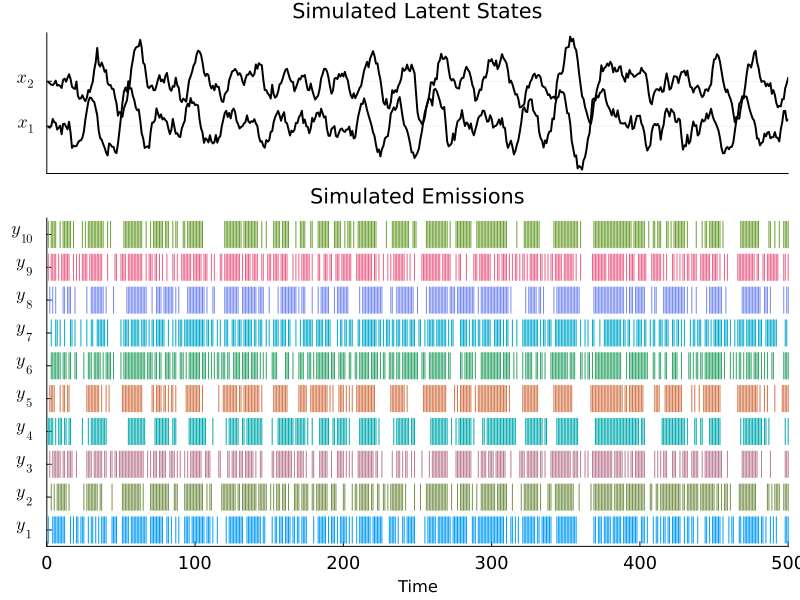

In [4]:
# plot the latent factors and the observations 

# Define parameters
state_dim = 2
obs_dim = 10
time_bins = 500

# Generate sample data
states = latents[:, :, 1]
emissions = observations[:, :, 1]

# Create the main plot
plot(size=(800, 600), layout=@layout[a{0.3h}; b])

# Plot the continuous latent states
lim_states = maximum(abs.(states))
for d in 1:state_dim
    plot!(1:time_bins, states[d, :] .+ lim_states * (d-1), color=:black, linewidth=2, label="", subplot=1)
end

plot!(subplot=1, yticks=(lim_states .* (0:state_dim-1), [L"x_%$d" for d in 1:state_dim]),
      xticks=[], xlims=(0, time_bins), title="Simulated Latent States",
      yformatter=y->"", tickfontsize=12)

# Plot the discrete observations as an event plot
colors = palette(:default, obs_dim)
for f in 1:obs_dim
    spike_times = findall(x -> x > 0, emissions[f, :])
    for t in spike_times
        plot!([t, t], [f-0.4, f+0.4], color=colors[f], linewidth=1, label="", subplot=2)
    end
end

# Adjust the observation subplot
plot!(subplot=2, yticks=(1:obs_dim, [L"y_{%$d}" for d in 1:obs_dim]),
      xlims=(0, time_bins), ylims=(0.5, obs_dim+0.5), title="Simulated Emissions",
      xlabel="Time", tickfontsize=12, grid=false)

## Create and fit a Poisson LDS model to Data

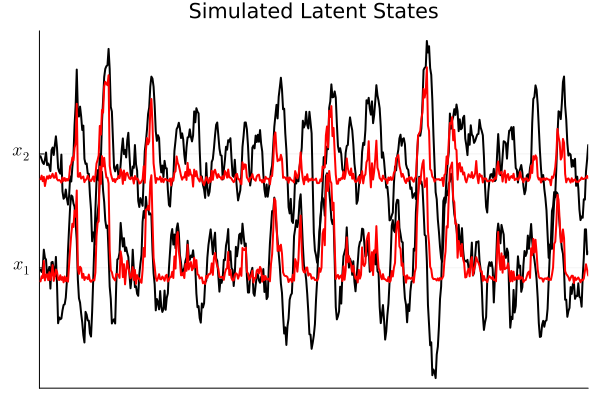

In [5]:
# create a Poisson LDS with unknown parameters
naive_ssm = PoissonLDS(;obs_dim=obs_dim, latent_dim=latent_dim, fit_bool=fill(true, 6))

# smooth observations using the naive model
smoothed_x, smoothed_p, _ = smooth(naive_ssm, observations)

# plot the smoothed latent factors and the observations
plot()

# Plot the (true) continuous latent states
for d in 1:state_dim
    plot!(1:time_bins, states[d, :] .+ lim_states * (d-1), color=:black, linewidth=2, label="", subplot=1)
end

# Plot the (smoothed) continuous latent states
for d in 1:state_dim
    plot!(1:time_bins, smoothed_x[d, :, 1] .+ lim_states * (d-1), color=:red, linewidth=2, label="", subplot=1)
end

plot!(subplot=1, yticks=(lim_states .* (0:state_dim-1), [L"x_%$d" for d in 1:state_dim]),
      xticks=[], xlims=(0, time_bins), title="Simulated Latent States",
      yformatter=y->"", tickfontsize=12)

Fitting Poisson LDS via LaPlaceEM... 100%|██████████████████████████████████████████████████| Time: 0:03:48 ( 9.16  s/it)


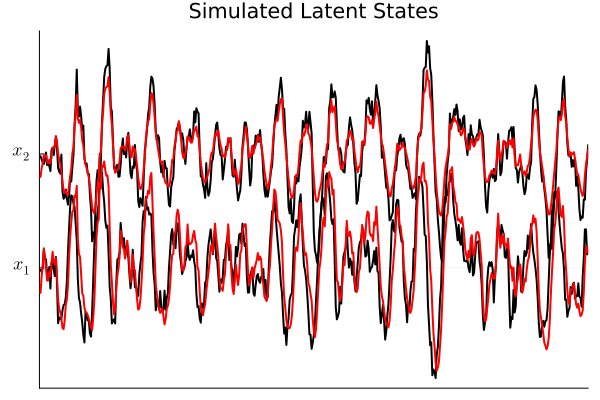

In [6]:
# fit model using LaPlaceEM
elbo, _ = fit!(naive_ssm, observations; max_iter=25, tol=1e-6)

# smooth observations using the naive model
smoothed_x, smoothed_p, _ = smooth(naive_ssm, observations)

# plot the smoothed latent factors and the observations
plot()

# Plot the (true) continuous latent states
for d in 1:state_dim
    plot!(1:time_bins, states[d, :] .+ lim_states * (d-1), color=:black, linewidth=2, label="", subplot=1)
end

# Plot the (smoothed) continuous latent states
for d in 1:state_dim
    plot!(1:time_bins, smoothed_x[d, :, 1] .+ lim_states * (d-1), color=:red, linewidth=2, label="", subplot=1)
end

plot!(subplot=1, yticks=(lim_states .* (0:state_dim-1), [L"x_%$d" for d in 1:state_dim]),
      xticks=[], xlims=(0, time_bins), title="Simulated Latent States",
      yformatter=y->"", tickfontsize=12)


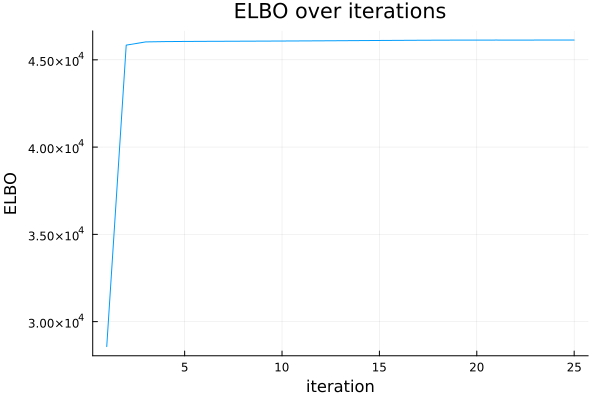

In [7]:
plot(elbo, xlabel="iteration", ylabel="ELBO", title="ELBO over iterations", legend=false)